In [87]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import csv
import seaborn as sns
import scipy.io
import torch
import torch.nn as nn  
import torch.optim as optim  
import torch.nn.functional as F  
import torchvision.datasets as datasets  
import torchvision.transforms as transforms  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
import os
from scipy.signal import butter, filtfilt
import pywt
from scipy import signal
from tqdm import tqdm

# Data preprocessing and feature extraction

In [88]:
data_root = '/kaggle/input/EEG Data/'
files = os.listdir(data_root)
len(files)

34

In [91]:
file_names=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))
        

In [92]:
mat = scipy.io.loadmat(file_names[1])
data = mat['o']['data'][0,0]
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

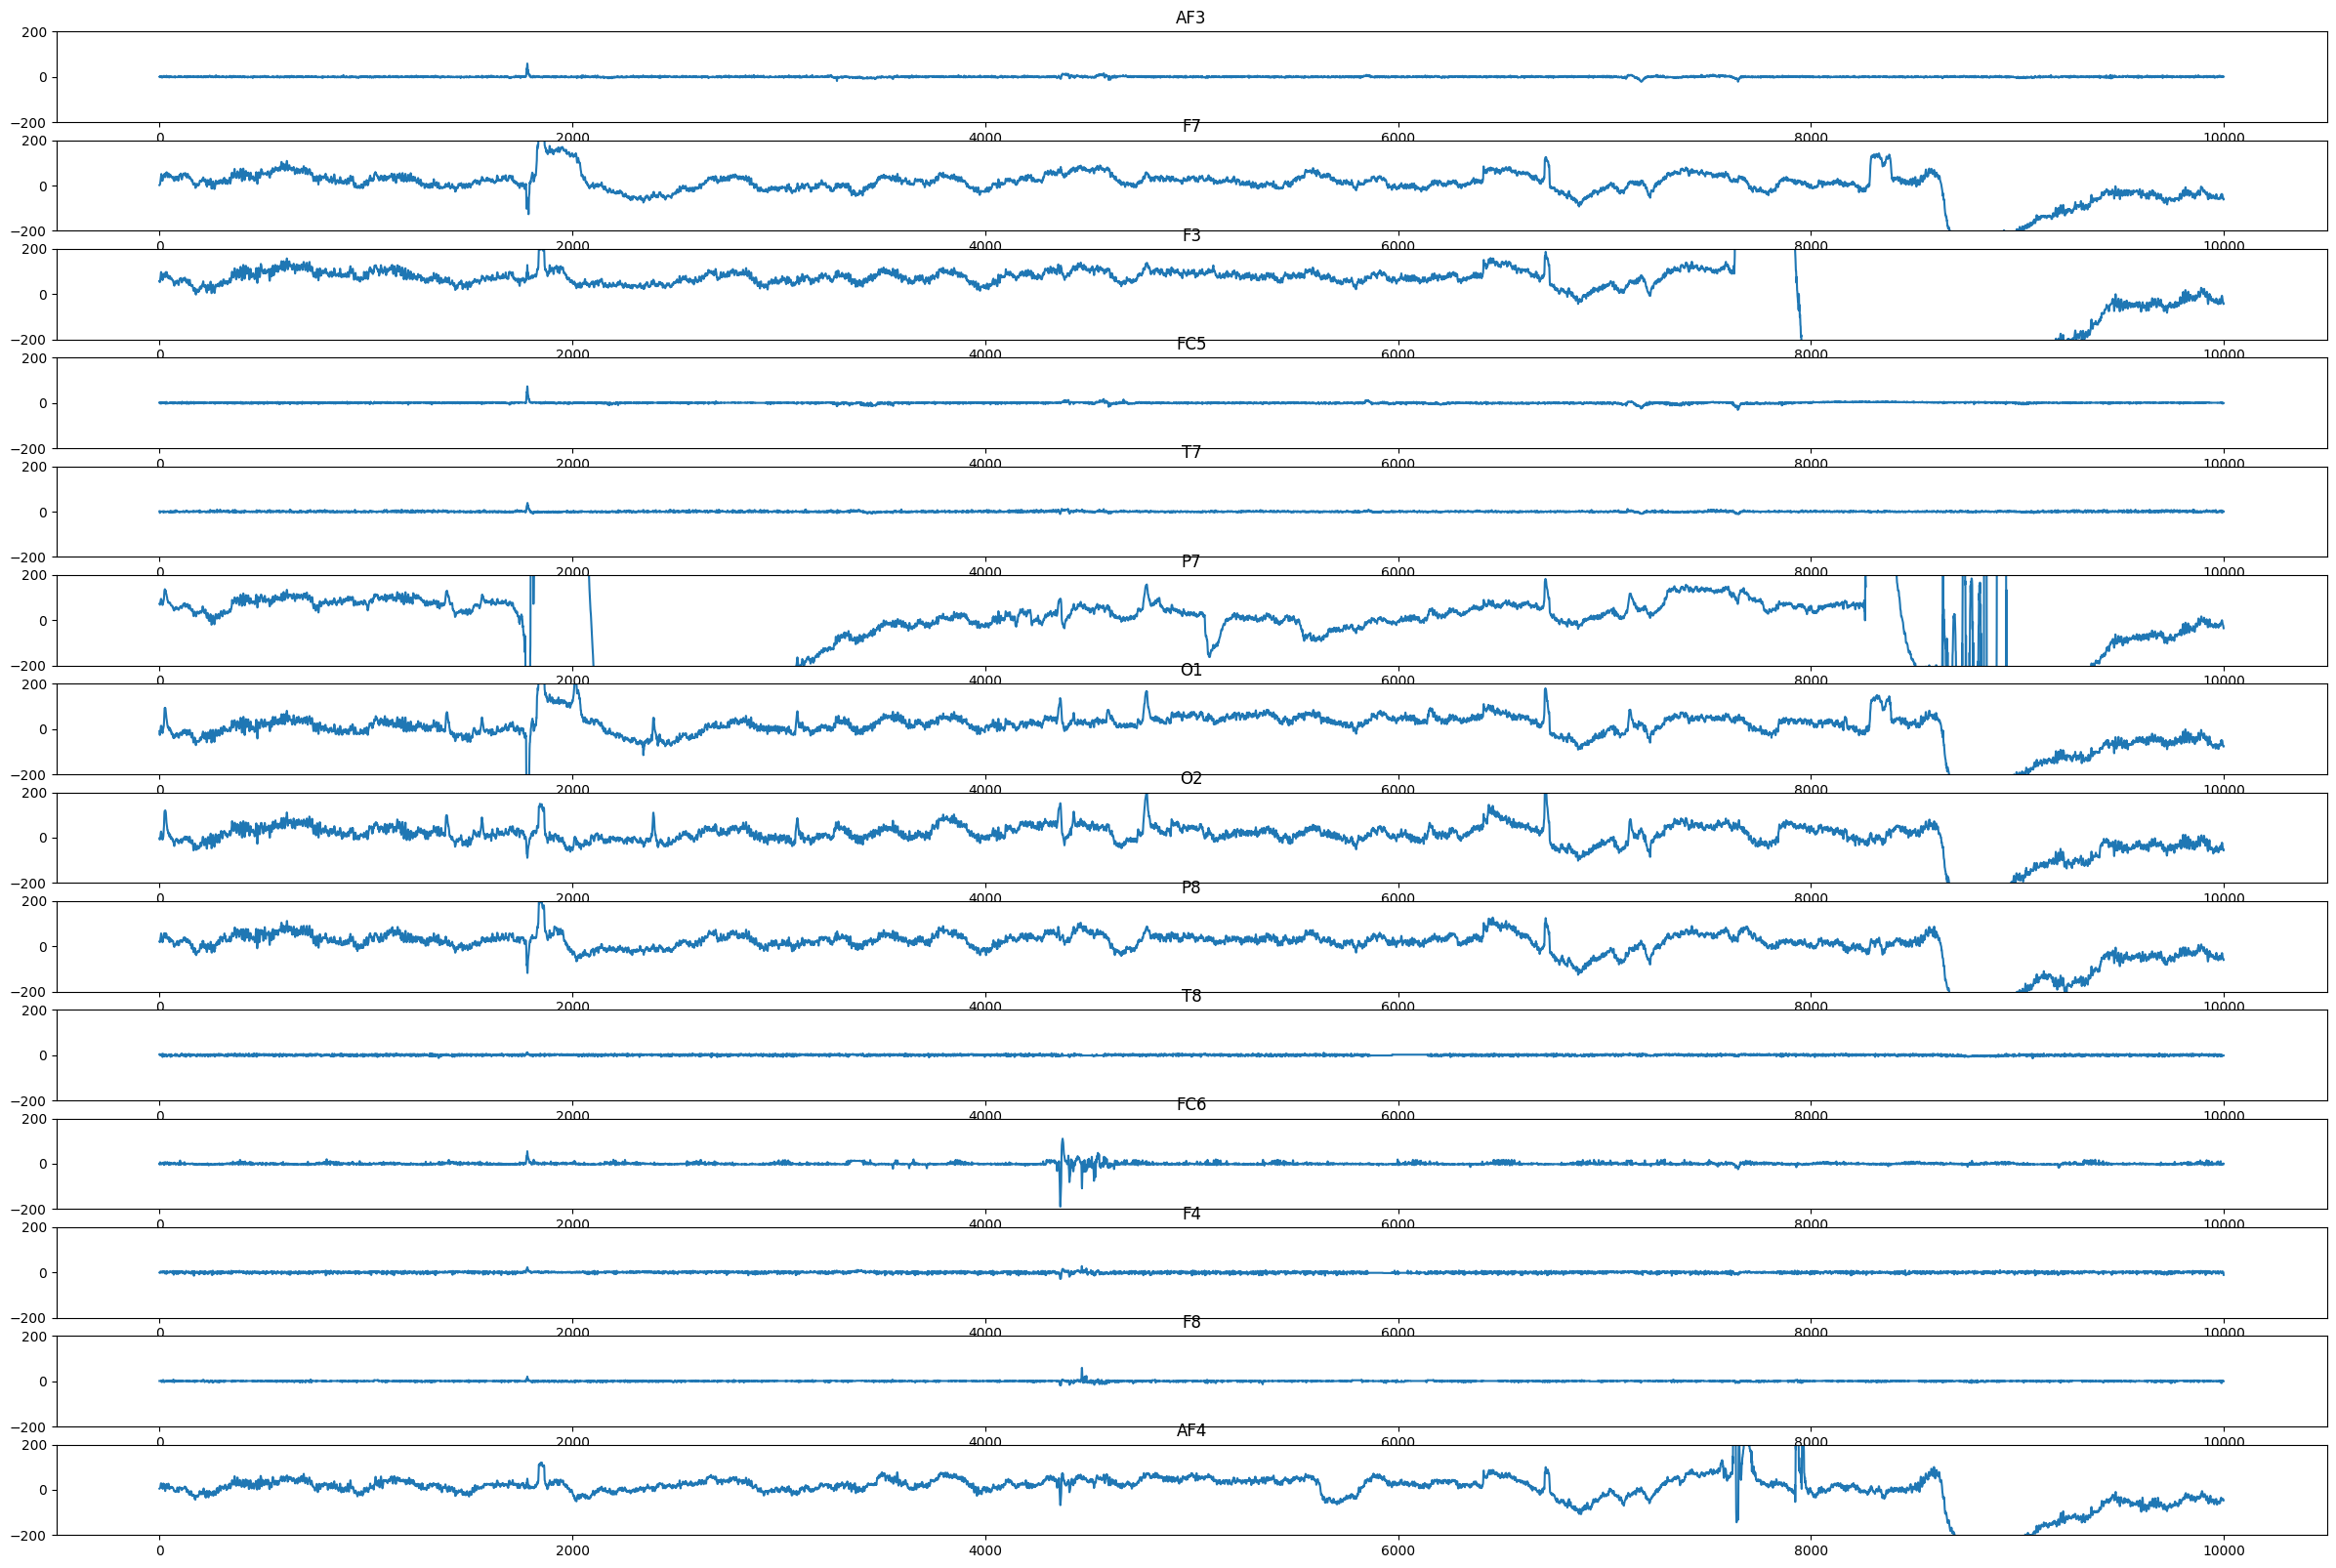

In [93]:
fig, ax = plt.subplots(14,1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30,20)
for i in range(14):
    data_ave = data[5000:15000,i+3]-np.mean(data[5000:15000,i+3]) #+3 because 3 first channel aren't EEG data
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-200,200)

plt.savefig('my_image1.png')

In [89]:
FOCUSED_CLASS = 0
UNFOCUSED_CLASS = 1
DROWNSY_CLASS = 2

In [90]:
columns = [
    'ED_COUNTER',    'ED_INTERPOLATED',    'ED_RAW_CQ',    'ED_AF3',    'ED_F7',
    'ED_F3',    'ED_FC5',    'ED_T7',    'ED_P7',    'ED_O1',
    'ED_O2',    'ED_P8',    'ED_T8',    'ED_FC6',    'ED_F4',
    'ED_F8',    'ED_AF4',    'ED_GYROX',    'ED_GYROY',    'ED_TIMESTAMP',
    'ED_ES_TIMESTAMP',    'ED_FUNC_ID',    'ED_FUNC_VALUE',    'ED_MARKER',    'ED_SYNC_SIGNAL'
]

def get_state(timestamp):
    if timestamp <= 10*128*60:
        return FOCUSED_CLASS
    elif timestamp > 20*128*60:
        return UNFOCUSED_CLASS
    else:
        return DROWNSY_CLASS

scaler = StandardScaler()


Creating RawArray with float64 data, n_channels=14, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_23/441512570.py:20: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 2.9s.


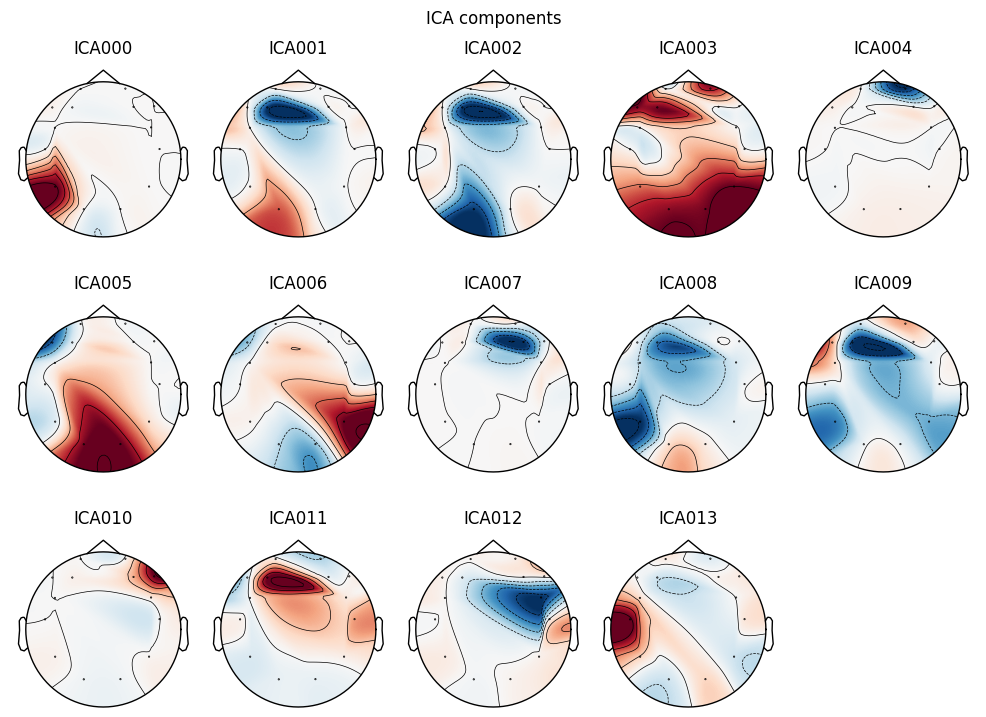

Creating RawArray with float64 data, n_channels=14, n_times=363232
    Range : 0 ... 363231 =      0.000 ...  2837.742 secs
Ready.


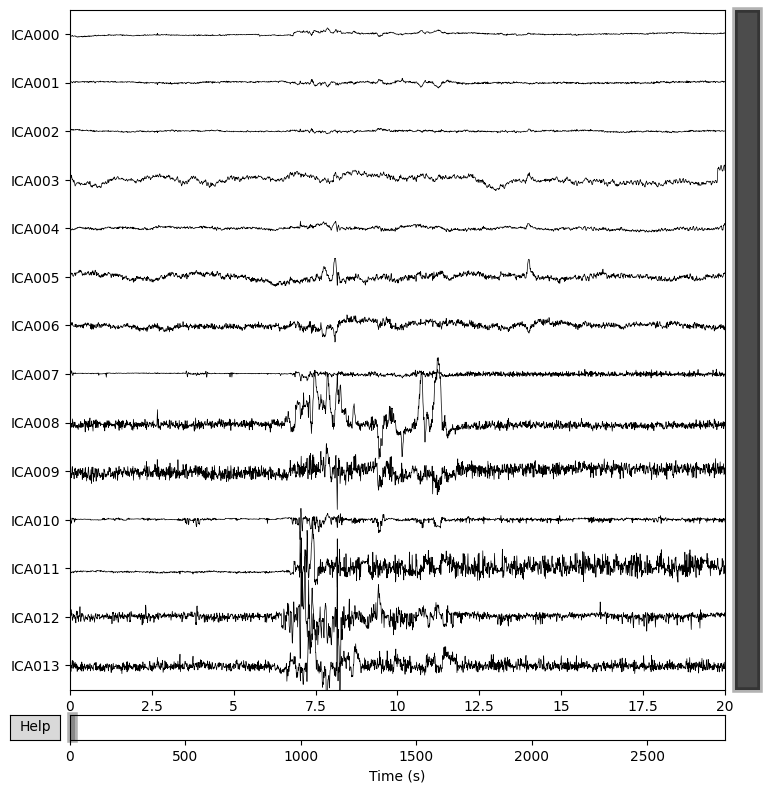

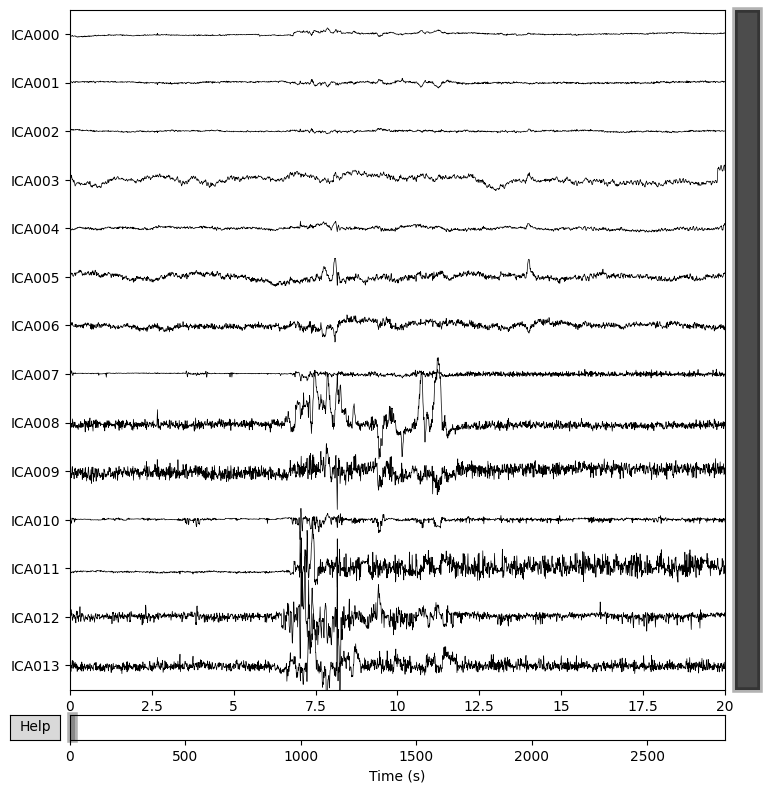

In [94]:
import mne
from mne.preprocessing import ICA
from mne.io import read_raw_fif
from mne import create_info
from mne.channels import make_standard_montage
from mne.viz import plot_topomap

SAMPLE_RATE = mat['o']['sampFreq'][0][0][0][0]
info = create_info(ch_names=channels, sfreq=SAMPLE_RATE, ch_types="eeg")
data_viz = data[:, 3:17]
data_viz = data_viz.T
raw = mne.io.RawArray(data_viz, info)

# montage (vị trí của các điện cực trên đầu)
montage = make_standard_montage('standard_1020')
raw.set_montage(montage)

# Apply ICA
ica = ICA(n_components=14, random_state=97, max_iter=800)
ica.fit(raw)

# Vẽ topographic map của các thành phần ICA
ica.plot_components()

# Phân tích các thành phần ICA: xác định các thành phần artifacts (chẳng hạn như blink mắt)
ica.plot_sources(raw)

It seems like only 7 channels are usefull here so we are going to select them

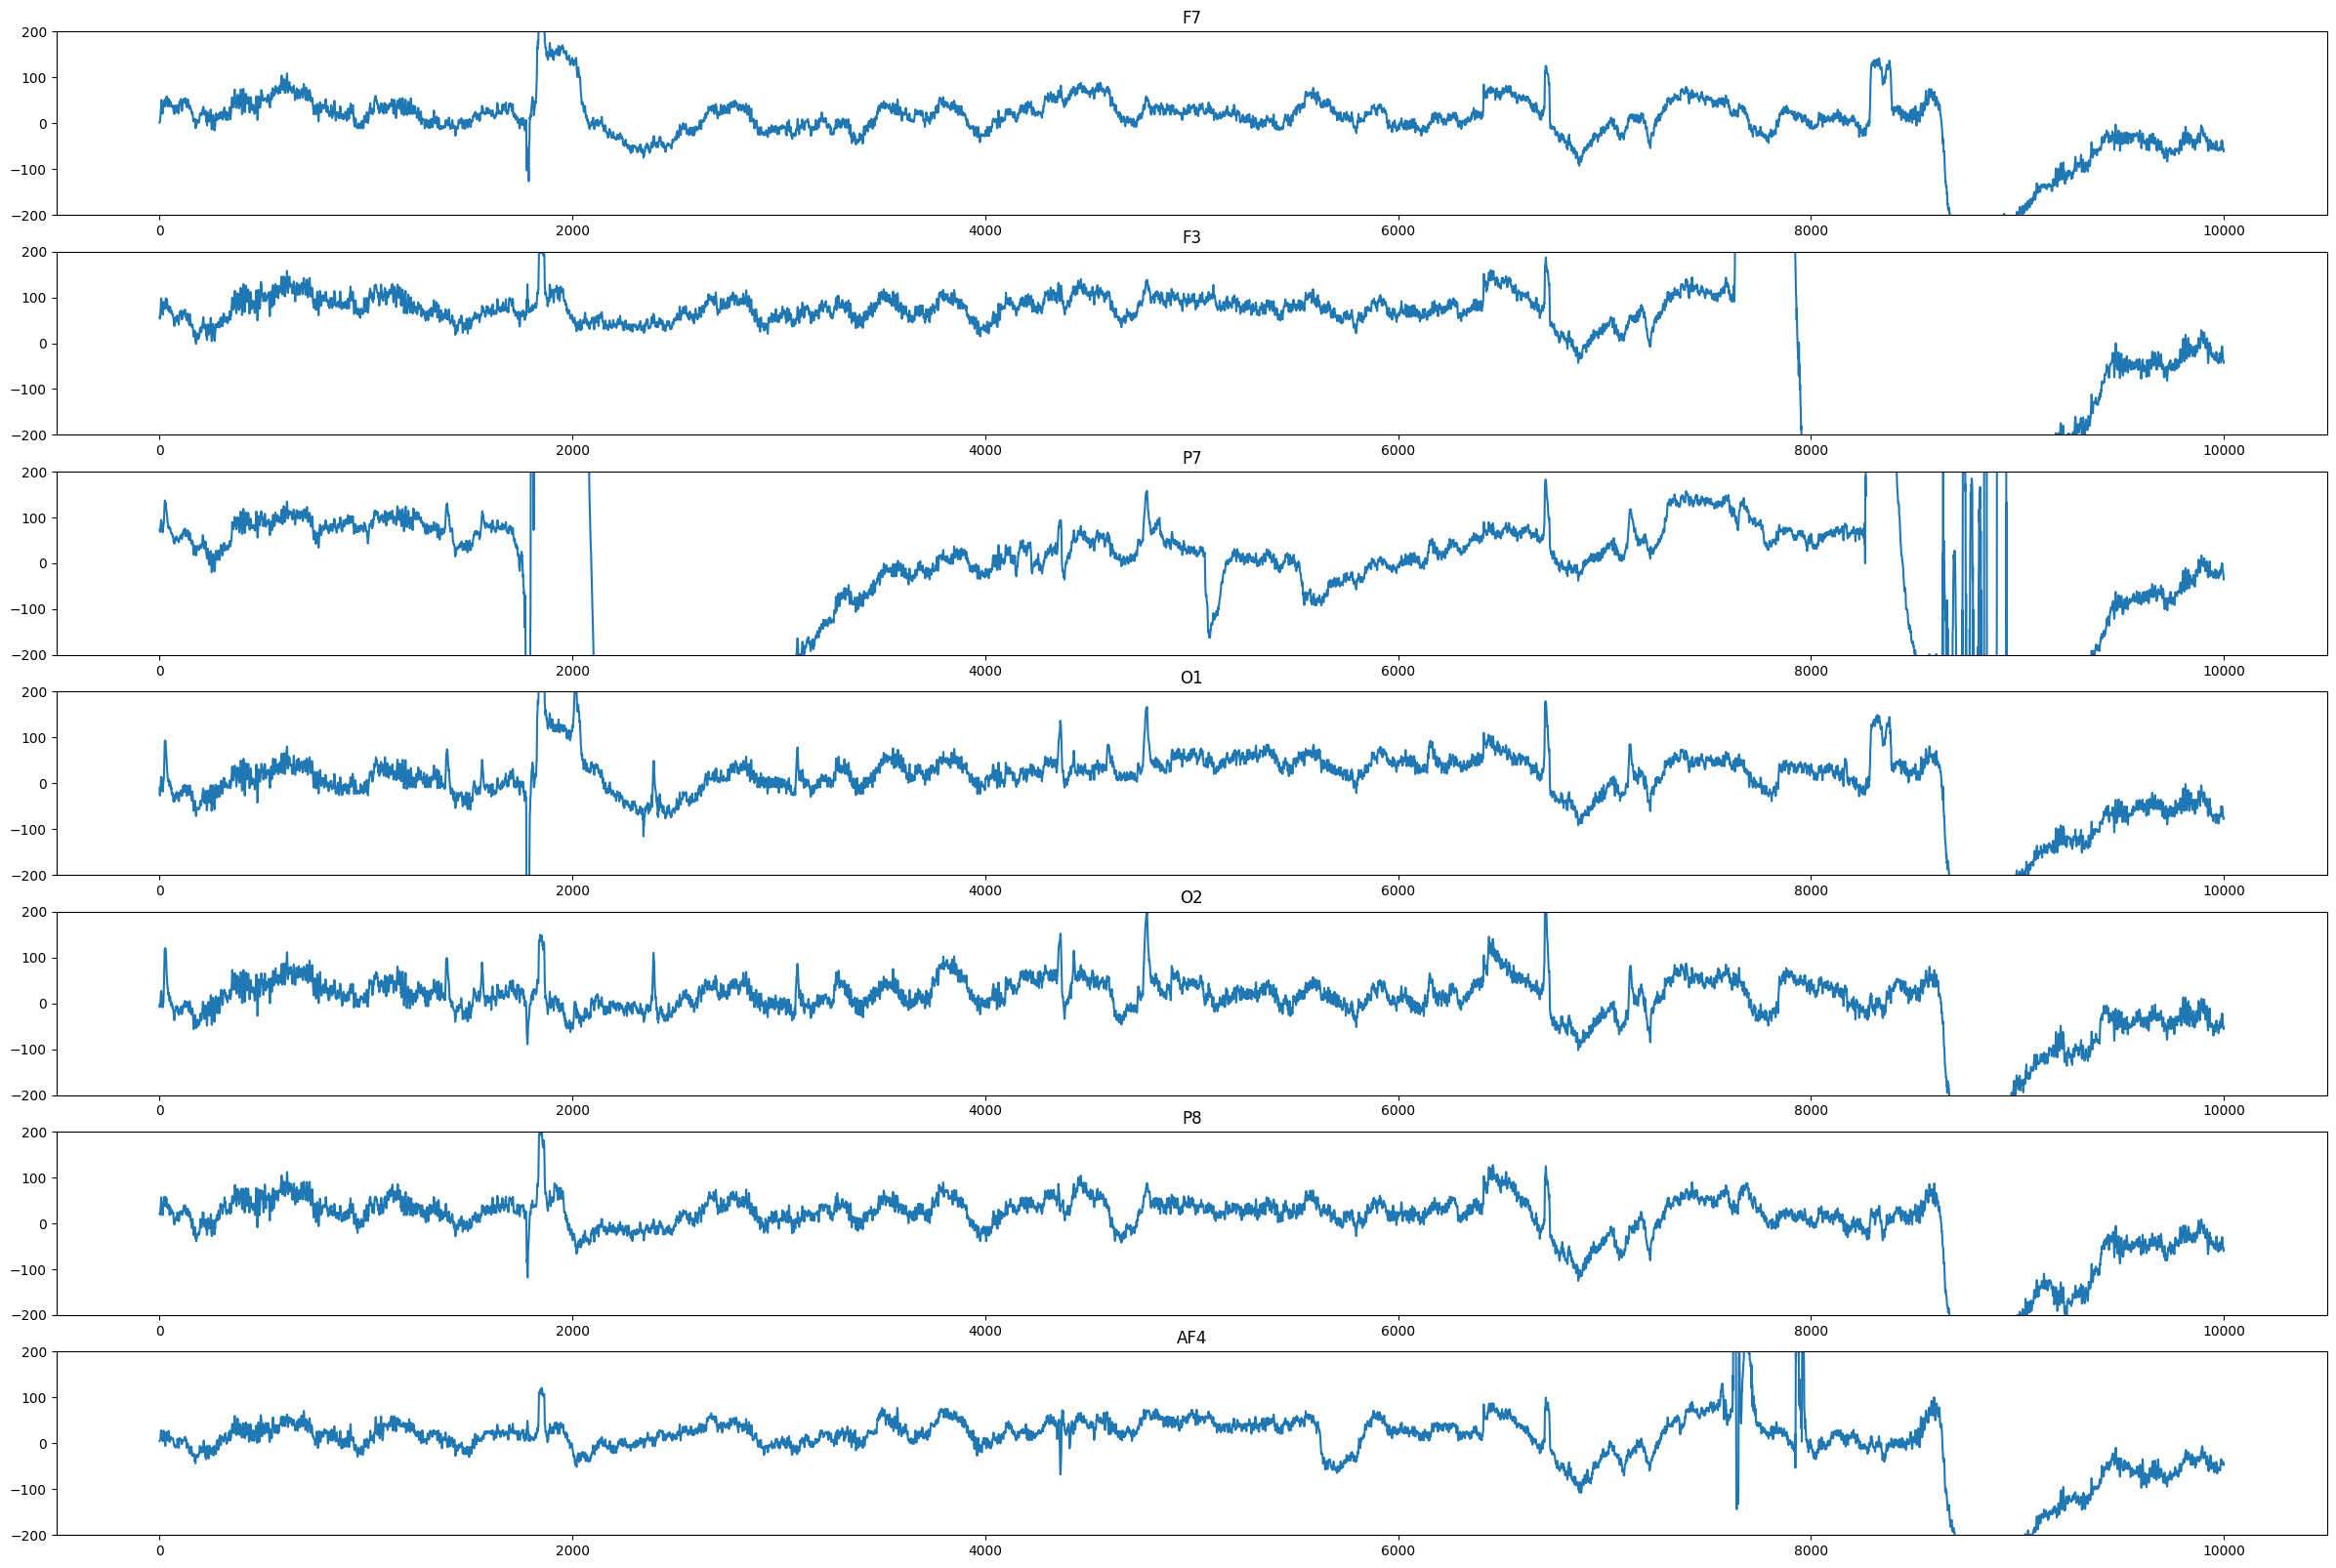

In [95]:
USEFUL_CHANNELS = np.array([1,2,5,6,7,8,13]) + 3 # these are the indices of the interesting channels
SAMPLE_RATE = mat['o']['sampFreq'][0][0][0][0]

channels = ['F7', 'F3', 'P7', 'O1', 'O2', 'P8', 'AF4']

fig, ax = plt.subplots(7,1)
fig.set_figwidth(20)
fig.set_figheight(50)
fig.set_size_inches(30,20)
for i, j in enumerate(USEFUL_CHANNELS):
    data_ave = data[5000:15000,j]-np.mean(data[5000:15000,j]) 
    ax[i].plot(data_ave)
    ax[i].set_title(channels[i])
    ax[i].set_ylim(-200,200)

plt.savefig('my_image2.png')

### Lọc thông dải (Band-Pass Filter)

In [96]:
def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  
    b_lo = f_lo / f_ny  
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt

In [113]:
def get_EEG_data(data_root, filename, f_lo, f_hi, fs):
    hz = 128
    mat = scipy.io.loadmat(data_root + filename)
    data = mat["o"]["data"][0,0]
    eeg_df = pd.DataFrame(data, columns=columns)
    eeg_df = eeg_df.filter(['ED_AF3', 'ED_F7', 'ED_F3', 'ED_FC5', 
                            'ED_T7', 'ED_P7', 'ED_O1', 'ED_O2', 
                            'ED_P8', 'ED_T8', 'ED_FC6', 'ED_F4',
                            'ED_F8', 'ED_AF4'])
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1','O2','P8','T8', 'FC6','F4','F8','AF4']
    eeg_df.columns = labels

    # Áp dụng lọc thông dải
    eeg_array = eeg_df.to_numpy()
    eeg_filtered = bp_filter(eeg_array, f_lo, f_hi, fs)
    eeg_df = pd.DataFrame(eeg_filtered, columns=labels)
    eeg_df = pd.DataFrame(scaler.fit_transform(eeg_df), columns=eeg_df.columns)
    eeg_df.reset_index(inplace=True)
    eeg_df.rename(columns={'index': 'timestamp'}, inplace=True)

    eeg_df['state'] = eeg_df['timestamp'].apply(get_state)
    return eeg_df

In [114]:
dataset = []
for filename in files:
    data = get_EEG_data(data_root, filename,f_lo=2, f_hi=50, fs=128)
    dataset.append(data)
dataset[0]

,timestamp,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,state
0,0,1.718485,0.124851,0.089737,0.367016,2.069568,0.297311,0.371509,1.031051,0.725276,-4.307598,2.785929,0.134446,-0.011837,1.121763,0
1,1,1.718485,0.097693,0.097372,-0.109431,1.631122,0.306414,0.292444,1.058949,0.691122,-2.480892,4.578951,0.134446,-0.078654,1.106471,0
2,2,0.820101,0.097693,0.074469,-0.347654,1.192675,0.338277,0.495753,1.240286,0.738938,3.811095,2.965231,0.134446,-0.011837,1.083533,0
3,3,0.178398,0.124851,0.097372,0.287609,1.046527,0.324622,0.608702,1.323980,0.807246,5.231867,2.427325,0.134446,-0.011837,1.175286,0
4,4,0.050057,0.141146,0.105006,1.955174,1.631122,0.297311,0.337624,1.114745,0.773092,0.157683,1.889418,0.134446,-0.078654,1.175286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415159,415159,-4.185184,-1.879448,-4.696884,-3.285745,-2.022597,-1.209346,-1.175893,-1.410019,-0.593070,-0.045284,-3.489647,-0.230082,0.054980,-1.217948,1
415160,415160,-4.313525,-1.863153,-4.857201,-1.856404,-1.730300,-1.436937,-1.142008,-1.382121,-0.572578,-0.654186,-4.027554,-0.230082,0.054980,-1.187363,1
415161,415161,-9.062129,-1.792541,-4.727421,-5.270941,-10.645373,-0.949891,-0.690212,-1.256581,-0.524762,-0.248251,-2.951741,-0.230082,-0.145472,-1.087964,1
415162,415162,-8.292085,-1.727360,-4.498396,-7.097322,-11.960712,-0.399120,-0.170646,-1.423968,-0.517931,1.172520,-2.413834,-0.230082,-0.145472,-1.072671,1


# Load dataset

In [115]:
class LoadData(Dataset):
    def __init__(self, dataset, target_column='state', wavelet='db6', level=4):
        self.data = []
        self.targets = []
        self.dataset = dataset
        dataframes = self.load_data()
        
        for df in dataframes:
            self.targets.append(df[target_column].mode()[0])
            feature = df.drop(columns=[target_column, 'timestamp'], errors='ignore')
            self.data.append(feature.values)

        self.data = torch.tensor(self.data, dtype=torch.float32)
        self.targets = torch.tensor(self.targets, dtype=torch.float32)

    def load_data(self):
        data = []
        for eeg in self.dataset:
            epochs = self.split_data(eeg, 128)
            for epoch in epochs:  
                data.append(epoch)  
        return data
        
    def split_data(self, data, hz, epoch_length=2, step_size=0.125):
        step = int(epoch_length * hz - step_size * hz)
        offset = int(epoch_length * hz)
        starts = []
        current = 0

        while current + offset <= data.shape[0]:
            starts.append(current)
            current += step
        ends = [x + offset for x in starts]
        epochs = []
        
        for i in range(len(starts)):
            epoch = data.iloc[starts[i]:ends[i]] 
            epochs.append(epoch)
        return epochs
    
    def __len__(self):
        return len(self.targets) 

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

eeg_dataset = LoadData(dataset)

In [119]:
train_size = int(0.8 * len(eeg_dataset)) 
val_size = int(0.1 * len(eeg_dataset))  
test_size = len(eeg_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(eeg_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Deep Learning models

In [128]:
# Hyperparameters
learning_rate = 0.002
num_epochs = 11
input_size = 14
num_layers = 2
hidden_size = 256
num_classes = 3
drop_out = 0.3

### Attention-based BiLSTM

In [121]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        weights = F.softmax(self.attention(lstm_output), dim=1)  # (batch, seq_len, 1)
        context = torch.sum(weights * lstm_output, dim=1)  # Weighted sum across time steps
        return context

# Attention BiLSTM Model
class AttentionBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.5):
        super(AttentionBiLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        # BiLSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = Attention(hidden_size * 2)  # Hidden size * 2 for bidirectional LSTM
        
        # Fully connected layers after attention
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Initialization
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        # BiLSTM
        lstm_out, _ = self.lstm(x, (h0, c0))  # (batch, seq_len, hidden_size*2)
        
        # Attention mechanism
        context = self.attention(lstm_out)  # (batch, hidden_size*2)
        
        # fully connected layers
        out = F.relu(self.fc1(context))
        out = F.relu(self.fc2(out))
        out = self.fc3(self.dropout(out))

        return out


### LSTM

In [132]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # LSTM layer
        self.lstm_model = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initialization
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate
        out, _ = self.lstm_model(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

### CNN-BiGRU

In [107]:
class CNN_BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.4):
        super(CNN_BiGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # CNN layers
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1) 
        self.bn2 = nn.BatchNorm1d(128)
        self.pool = nn.MaxPool1d(kernel_size=2)

        # BiGRU
        self.gru = nn.GRU(128, hidden_size, num_layers, batch_first=True, bidirectional=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = x.permute(0, 2, 1)

        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = F.relu(self.dropout(self.fc1(out[:, -1, :])))
        out = self.fc2(self.dropout(out))

        return out


### Training and evaluating

In [126]:
def train_model(model, num_epochs, train_loader, val_loader, criterion, optimizer, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
            data = data.to(device=device).squeeze(1)
            targets = targets.to(device=device).long()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                # Move data and targets to device
                data = data.to(device=device).squeeze(1)
                targets = targets.to(device=device).long()

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, targets)

                # Accumulate metrics
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [127]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for data, targets in test_loader:
            data = data.to(device).squeeze(1)
            targets = targets.to(device).long()

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    # Calculate average loss and accuracy
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

Train LSTM-Attention model

In [143]:
attention_bilstm_model = AttentionBiLSTM(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(attention_bilstm_model.parameters(), lr=learning_rate)

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    attention_bilstm_model, num_epochs, train_loader, val_loader, criterion, optimizer, device
)
test_loss, test_accuracy = test_model(model, val_loader, criterion, device)

Epoch 1/11 [Training]:   4%|▎         | 184/5212 [00:05<02:47, 29.93it/s]

Train CNN_BiGRU model

In [131]:
model = CNN_BiGRU(input_size=input_size, hidden_size = 256, num_layers=2, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, num_epochs, train_loader, val_loader, criterion, optimizer, device
)

test_loss, test_accuracy = test_model(model, val_loader, criterion, device)

Epoch 1/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 57.13it/s]


Epoch 1/11 - Train Loss: 0.75, Train Accuracy: 68.53%


Epoch 1/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 159.39it/s]


Epoch 1/11 - Val Loss: 0.60, Val Accuracy: 72.31%


Epoch 2/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.91it/s]


Epoch 2/11 - Train Loss: 0.67, Train Accuracy: 70.79%


Epoch 2/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 159.44it/s]


Epoch 2/11 - Val Loss: 0.60, Val Accuracy: 70.39%


Epoch 3/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.72it/s]


Epoch 3/11 - Train Loss: 0.64, Train Accuracy: 71.82%


Epoch 3/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 157.74it/s]


Epoch 3/11 - Val Loss: 0.59, Val Accuracy: 74.42%


Epoch 4/11 [Training]: 100%|██████████| 5212/5212 [01:32<00:00, 56.47it/s]


Epoch 4/11 - Train Loss: 0.63, Train Accuracy: 72.34%


Epoch 4/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 157.22it/s]


Epoch 4/11 - Val Loss: 0.49, Val Accuracy: 78.26%


Epoch 5/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.73it/s]


Epoch 5/11 - Train Loss: 0.61, Train Accuracy: 72.99%


Epoch 5/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 160.22it/s]


Epoch 5/11 - Val Loss: 0.54, Val Accuracy: 72.29%


Epoch 6/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.77it/s]


Epoch 6/11 - Train Loss: 0.61, Train Accuracy: 73.09%


Epoch 6/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.35it/s]


Epoch 6/11 - Val Loss: 0.49, Val Accuracy: 78.30%


Epoch 7/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.73it/s]


Epoch 7/11 - Train Loss: 0.60, Train Accuracy: 73.41%


Epoch 7/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 160.55it/s]


Epoch 7/11 - Val Loss: 0.53, Val Accuracy: 78.66%


Epoch 8/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.93it/s]


Epoch 8/11 - Train Loss: 0.60, Train Accuracy: 73.54%


Epoch 8/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 155.68it/s]


Epoch 8/11 - Val Loss: 0.53, Val Accuracy: 78.26%


Epoch 9/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.93it/s]


Epoch 9/11 - Train Loss: 0.60, Train Accuracy: 73.67%


Epoch 9/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.10it/s]


Epoch 9/11 - Val Loss: 0.51, Val Accuracy: 74.76%


Epoch 10/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.88it/s]


Epoch 10/11 - Train Loss: 0.60, Train Accuracy: 73.58%


Epoch 10/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 157.52it/s]


Epoch 10/11 - Val Loss: 0.53, Val Accuracy: 78.30%


Epoch 11/11 [Training]: 100%|██████████| 5212/5212 [01:31<00:00, 56.89it/s]


Epoch 11/11 - Train Loss: 0.60, Train Accuracy: 73.76%


Epoch 11/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.45it/s]


Epoch 11/11 - Val Loss: 0.49, Val Accuracy: 77.41%
Test Loss: 0.5183, Test Accuracy: 76.87%


Train LSTM model

In [133]:
model = LSTM(input_size=input_size, hidden_size=256, num_layers = 2, num_classes=num_classes).to(device)
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, num_epochs, train_loader, val_loader, criterion, optimizer, device
)

test_loss, test_accuracy = test_model(model, val_loader, criterion, device)

Epoch 1/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.64it/s]


Epoch 1/11 - Train Loss: 0.86, Train Accuracy: 63.29%


Epoch 1/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 157.39it/s]


Epoch 1/11 - Val Loss: 0.71, Val Accuracy: 70.37%


Epoch 2/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 65.05it/s]


Epoch 2/11 - Train Loss: 0.72, Train Accuracy: 70.06%


Epoch 2/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 159.77it/s]


Epoch 2/11 - Val Loss: 0.70, Val Accuracy: 70.89%


Epoch 3/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.95it/s]


Epoch 3/11 - Train Loss: 0.67, Train Accuracy: 72.00%


Epoch 3/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 150.22it/s]


Epoch 3/11 - Val Loss: 0.68, Val Accuracy: 71.10%


Epoch 4/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.83it/s]


Epoch 4/11 - Train Loss: 0.65, Train Accuracy: 72.72%


Epoch 4/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 156.57it/s]


Epoch 4/11 - Val Loss: 0.71, Val Accuracy: 68.64%


Epoch 5/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.84it/s]


Epoch 5/11 - Train Loss: 0.63, Train Accuracy: 73.36%


Epoch 5/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 149.87it/s]


Epoch 5/11 - Val Loss: 0.62, Val Accuracy: 73.77%


Epoch 6/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.88it/s]


Epoch 6/11 - Train Loss: 0.62, Train Accuracy: 73.88%


Epoch 6/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.73it/s]


Epoch 6/11 - Val Loss: 0.66, Val Accuracy: 71.71%


Epoch 7/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.62it/s]


Epoch 7/11 - Train Loss: 0.63, Train Accuracy: 73.41%


Epoch 7/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.95it/s]


Epoch 7/11 - Val Loss: 0.62, Val Accuracy: 73.54%


Epoch 8/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.59it/s]


Epoch 8/11 - Train Loss: 0.65, Train Accuracy: 72.15%


Epoch 8/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 158.09it/s]


Epoch 8/11 - Val Loss: 0.70, Val Accuracy: 70.33%


Epoch 9/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.96it/s]


Epoch 9/11 - Train Loss: 0.64, Train Accuracy: 72.35%


Epoch 9/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 159.46it/s]


Epoch 9/11 - Val Loss: 0.65, Val Accuracy: 72.08%


Epoch 10/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.62it/s]


Epoch 10/11 - Train Loss: 0.61, Train Accuracy: 73.67%


Epoch 10/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 149.85it/s]


Epoch 10/11 - Val Loss: 0.60, Val Accuracy: 74.50%


Epoch 11/11 [Training]: 100%|██████████| 5212/5212 [01:20<00:00, 64.75it/s]


Epoch 11/11 - Train Loss: 0.60, Train Accuracy: 74.33%


Epoch 11/11 [Validation]: 100%|██████████| 652/652 [00:04<00:00, 159.06it/s]


Epoch 11/11 - Val Loss: 0.60, Val Accuracy: 74.96%
Test Loss: 0.5955, Test Accuracy: 75.00%


### Machine learning models

In [134]:
bands = {'alpha': (8, 13), 'delta': (0.5, 4), 'beta': (13, 30), 'gamma': (30, np.inf)}
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

def get_powers(channel, FS=128):
    channel = channel - channel.mean()
    freq, psd = signal.periodogram(channel, fs=FS, nfft=256)

    powers = {}
    for band_name, band_limits in bands.items():
        low, high = band_limits
        powers[band_name] = psd[(freq >= low) & (freq < high)].mean()
    return powers

In [135]:
subjects = list(range(1, 35))
print(subjects)
channel_indices = np.array(range(3, 17))
channel_names = ['F7', 'F3','P7','O1','O2','P8','F4','AF4']
channel_map = dict(zip(channel_names, channel_indices))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [136]:
rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            powers = get_powers(eeg[:, ch_idx])
            powers['state'] = state
            powers['channel'] = ch_name
            powers['subject'] = f"subject_{subject_idx}"
            rows_list.append(powers)

/tmp/ipykernel_23/3745562384.py:15: RuntimeWarning: Mean of empty slice.
  channel = channel - channel.mean()
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_23/3745562384.py:21: RuntimeWarning: Mean of empty slice.
  powers[band_name] = psd[(freq >= low) & (freq < high)].mean()


In [137]:
df = pd.DataFrame.from_dict(rows_list)
df = df.drop(columns=["subject"])
print(df.isna().sum())
df = df.dropna()
print(df.isna().sum())

alpha      8
delta      8
beta       8
gamma      8
state      0
channel    0
dtype: int64
alpha      0
delta      0
beta       0
gamma      0
state      0
channel    0
dtype: int64


In [138]:
df.head()

,alpha,delta,beta,gamma,state,channel
0,0.045083,0.541343,0.065691,0.035483,focused,F7
1,0.051634,0.063098,0.049342,0.027426,unfocused,F7
2,0.086027,0.150669,0.070423,0.038163,drowsy,F7
3,41.977120,3116.933568,11.147032,3.363977,focused,F3
4,178.797955,19571.352381,45.307899,12.836777,unfocused,F3


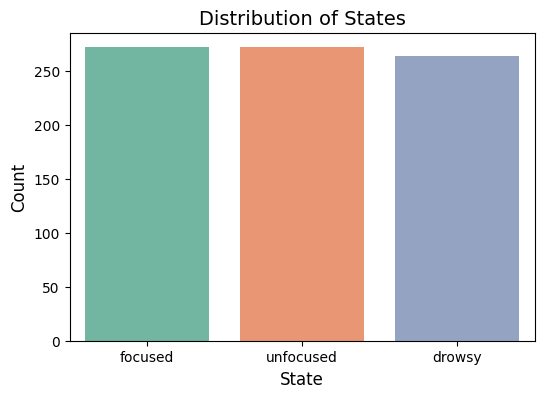

In [139]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='state', palette='Set2')

# Thêm tiêu đề và nhãn
plt.title("Distribution of States", fontsize=14)
plt.xlabel("State", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Hiển thị biểu đồ
plt.show()

##### Random Forest with hyperparameter tuning

In [140]:
label_encoder_state = LabelEncoder()
df['state_encoded'] = label_encoder_state.fit_transform(df['state'])
label_encoder_channel = LabelEncoder()
df['channel_encoded'] = label_encoder_channel.fit_transform(df['channel'])

# Chọn các feature và target
X = df[['alpha', 'delta', 'beta', 'gamma', 'channel_encoded']]
y = df['state_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 2000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    
    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy 

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=100)  
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print(f"  Params: {trial.params}")

best_rf_model = RandomForestClassifier(
    n_estimators=trial.params['n_estimators'],
    max_depth=trial.params['max_depth'],
    min_samples_split=trial.params['min_samples_split'],
    min_samples_leaf=trial.params['min_samples_leaf'],
    max_features=trial.params['max_features'],
    random_state=42
)

best_rf_model.fit(X_train, y_train)

y_pred_rf = best_rf_model.predict(X_test)
print("Optimized Random Forest:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder_state.classes_))


[I 2024-12-15 15:46:42,842] A new study created in memory with name: no-name-d9e73fa1-6d8e-4081-99f8-111ec5e811e5
[I 2024-12-15 15:46:44,904] Trial 0 finished with value: 0.6049382716049383 and parameters: {'n_estimators': 1001, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6049382716049383.
[I 2024-12-15 15:46:45,083] Trial 1 finished with value: 0.5308641975308642 and parameters: {'n_estimators': 98, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.6049382716049383.
[I 2024-12-15 15:46:48,350] Trial 2 finished with value: 0.43209876543209874 and parameters: {'n_estimators': 1815, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': None}. Best is trial 0 with value: 0.6049382716049383.
[I 2024-12-15 15:46:51,994] Trial 3 finished with value: 0.5925925925925926 and parameters: {'n_estimators': 1902, 'max_depth': 7, '

Best trial:
  Accuracy: 0.6111111111111112
  Params: {'n_estimators': 863, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 17, 'max_features': 'log2'}
Optimized Random Forest:
Accuracy: 0.6111111111111112
Classification Report:
              precision    recall  f1-score   support

      drowsy       0.67      0.53      0.59        55
     focused       0.59      0.68      0.63        53
   unfocused       0.59      0.63      0.61        54

    accuracy                           0.61       162
   macro avg       0.62      0.61      0.61       162
weighted avg       0.62      0.61      0.61       162



##### Logistic Regression model

In [141]:
def objective(trial):
    C = trial.suggest_float('C', 1e-5, 1e5)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga']) 
    
    model = LogisticRegression(C=C, solver=solver, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print(f"  Params: {trial.params}")

best_model = LogisticRegression(C=trial.params['C'], solver=trial.params['solver'], random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("Optimized Logistic Regression:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder_state.classes_))

[I 2024-12-15 15:50:02,639] A new study created in memory with name: no-name-3d1ef82f-64ca-4aaf-9ced-0da6b2d3e707
[I 2024-12-15 15:50:02,655] Trial 0 finished with value: 0.43209876543209874 and parameters: {'C': 47692.08352006108, 'solver': 'liblinear'}. Best is trial 0 with value: 0.43209876543209874.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2024-12-15 15:50:02,678] Trial 1 finished with value: 0.3271604938271605 and parameters: {'C': 84124.28242451083, 'solver': 'saga'}. Best is trial 0 with value: 0.43209876543209874.
[I 2024-12-15 15:50:02,689] Trial 2 finished with value: 0.4382716049382716 and parameters: {'C': 98906.16531785605, 'solver': 'liblinear'}. Best is trial 2 with value: 0.4382716049382716.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did n

Best trial:
  Accuracy: 0.46296296296296297
  Params: {'C': 10184.506810614535, 'solver': 'liblinear'}
Optimized Logistic Regression:
Accuracy: 0.46296296296296297
Classification Report:
              precision    recall  f1-score   support

      drowsy       0.58      0.38      0.46        55
     focused       0.47      0.51      0.49        53
   unfocused       0.40      0.50      0.44        54

    accuracy                           0.46       162
   macro avg       0.48      0.46      0.46       162
weighted avg       0.48      0.46      0.46       162



##### KNN

In [142]:
from sklearn.neighbors import KNeighborsClassifier
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 100)  # Số lượng láng giềng
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Phương thức tính trọng số
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev'])  # Đo lường khoảng cách

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)

    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print(f"  Params: {trial.params}")

best_model = KNeighborsClassifier(n_neighbors=trial.params['n_neighbors'], 
                                  weights=trial.params['weights'], 
                                  metric=trial.params['metric'])
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print("Optimized KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder_state.classes_))

[I 2024-12-15 15:50:04,536] A new study created in memory with name: no-name-b87aaae7-32df-4912-be03-e47cc607dfbe
[I 2024-12-15 15:50:04,545] Trial 0 finished with value: 0.4506172839506173 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 0 with value: 0.4506172839506173.
[I 2024-12-15 15:50:04,563] Trial 1 finished with value: 0.41975308641975306 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: 0.4506172839506173.
[I 2024-12-15 15:50:04,570] Trial 2 finished with value: 0.4691358024691358 and parameters: {'n_neighbors': 47, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 2 with value: 0.4691358024691358.
[I 2024-12-15 15:50:04,576] Trial 3 finished with value: 0.47530864197530864 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 3 with value: 0.47530864197530864.
[I 2024-12-15 15:50:04,583] Trial 4 finished with value:

Best trial:
  Accuracy: 0.4876543209876543
  Params: {'n_neighbors': 51, 'weights': 'distance', 'metric': 'manhattan'}
Optimized KNN:
Accuracy: 0.4876543209876543
Classification Report:
              precision    recall  f1-score   support

      drowsy       0.51      0.47      0.49        55
     focused       0.48      0.60      0.53        53
   unfocused       0.48      0.39      0.43        54

    accuracy                           0.49       162
   macro avg       0.49      0.49      0.48       162
weighted avg       0.49      0.49      0.48       162

